In [ ]:
import csv

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

RANDOM_SEED = 42

In [ ]:
dataset = 'dataset.csv'

In [ ]:
NUM_CLASSES = 14
num_timesteps = 10  # Set the number of timesteps based on your data
num_features = 42  # 21 landmarks * 2 coordinates

In [ ]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [ ]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [ ]:
# Create sequences
X_sequences = []
y_sequences = []

for i in range(len(X_dataset) - num_timesteps):
    X_sequences.append(X_dataset[i:i + num_timesteps])  # Extract sequences of landmarks
    y_sequences.append(y_dataset[i + num_timesteps])    # Get the label for the last step in the sequence

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)

(6548, 10, 42)


In [ ]:
# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.GRU(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GRU(64, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
# Define the model architecture with increased regularization and reduced complexity
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.GRU(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.Dropout(0.5),  # Increased dropout
    tf.keras.layers.GRU(32, kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.Dropout(0.5),  # Increased dropout
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 10, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 10, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,390 (427.30 KB)

 Trainable params: 108,878 (425.30 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-5)

In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32,validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.4051 - loss: 1.8807 - val_accuracy: 0.9048 - val_loss: 0.7054 - learning_rate: 0.0010
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8339 - loss: 0.6120 - val_accuracy: 0.9304 - val_loss: 0.2641 - learning_rate: 0.0010
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9055 - loss: 0.3689 - val_accuracy: 0.9579 - val_loss: 0.1834 - learning_rate: 0.0010
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9213 - loss: 0.3060 - val_accuracy: 0.9646 - val_loss: 0.1514 - learning_rate: 0.0010
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9442 - loss: 0.2355 - val_accuracy: 0.9487 - val_loss: 0.1908 - learning_rate: 0.0010
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9518 - loss: 0.2042 - val_accuracy: 0.9609 - val_loss: 0.1720 - learning_rate: 0.0010
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9550 - loss: 0

In [ ]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9913 - loss: 0.0536


In [ ]:
model_save_path = '/content/model.h5'
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [ ]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
[4.2280229e-07 5.6885858e-07 6.2070910e-07 9.9999130e-01 1.7816300e-06
 8.6235127e-07 3.6052383e-11 1.0106302e-06 7.9391032e-07 1.4521616e-08
 8.7560562e-07 1.8993724e-07 1.6352212e-06 3.5811858e-09]
3


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


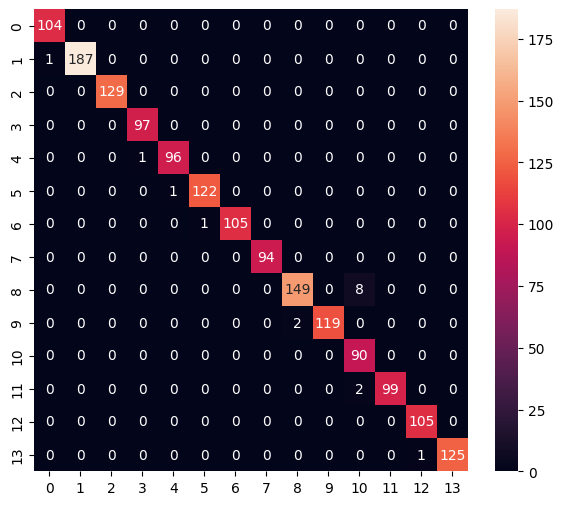

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       104
           1       1.00      0.99      1.00       188
           2       1.00      1.00      1.00       129
           3       0.99      1.00      0.99        97
           4       0.99      0.99      0.99        97
           5       0.99      0.99      0.99       123
           6       1.00      0.99      1.00       106
           7       1.00      1.00      1.00        94
           8       0.99      0.95      0.97       157
           9       1.00      0.98      0.99       121
          10       0.90      1.00      0.95        90
          11       1.00      0.98      0.99       101
          12       0.99      1.00      1.00       105
          13       1.00      0.99      1.00       126

    accuracy                           0.99      1638
   macro avg       0.99      0.99      0.99      1638
weighted avg       0.99      0.99      0.99      1638



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

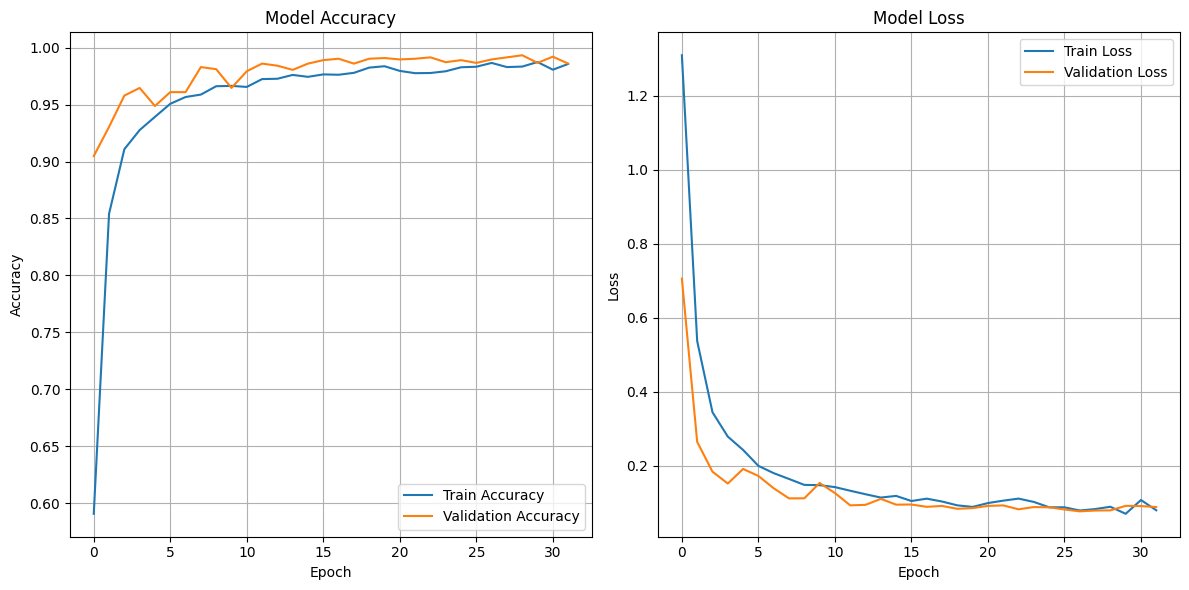

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from model.fit()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
tflite_save_path = 'model.tflite'

# Convert the Keras model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [ ]:
# Enable TensorFlow ops for unsupported TFLite ops
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,    # TFLite built-in ops
    tf.lite.OpsSet.SELECT_TF_OPS       # TensorFlow ops
]

In [ ]:
# Disable experimental lowering of TensorList ops (to avoid the error you're encountering)
converter._experimental_lower_tensor_list_ops = False

In [ ]:
# Apply optimizations for size reduction
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [ ]:
# Convert the model to TFLite format
tflite_quantized_model = converter.convert()

Saved artifact at '/tmp/tmpdp8cg2ge'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 42), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  133388317976432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133388317971328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133388317979424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133388318018896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133388318016080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133388318017312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133388318015728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133388318029808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133388318020304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133388318029104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133388318086368: 

In [ ]:
# Save the converted TFLite model
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)